# Empirical Application

In [8]:
# Potentially Download packages
!pip install autograd
!pip install pymanopt

# Imports
import numpy as np
import autograd.numpy as anp
from joblib import Parallel, delayed

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm, inv
from scipy.optimize import minimize

import pymanopt
import pymanopt.manifolds
import pymanopt.optimizers
from pymanopt.manifolds import Product, Euclidean, Stiefel, SymmetricPositiveDefinite
from pymanopt import Problem
from pymanopt.optimizers import SteepestDescent

# Define path
path = "/Users/v.d bosch/Documents/Github/Score-driven_Tensor_Factor_Model/"

np.set_printoptions(suppress=True, precision=4)

## Data

In [9]:
# Read in Country statistics
df_country = pd.read_excel(path+"Country_Statistics.xlsx",index_col=0)

# Show data
df_country

,Country Code,Continent,Income groups,GDP 2022
Argentina,ARG,South America,Upper-Middle-Income Economies,6.311334e+11
Australia,AUS,Oceania,High-Income Economies,1.692957e+12
Austria,AUT,Europe,High-Income Economies,4.709419e+11
Bangladesh,BGD,Asia,Lower-Middle-Income Economies,4.601317e+11
Belgium,BEL,Europe,High-Income Economies,5.836140e+11
Brazil,BRA,South America,Upper-Middle-Income Economies,1.951924e+12
Canada,CAN,North America,High-Income Economies,2.161483e+12
Chile,CHL,South America,High-Income Economies,3.021165e+11
"China, P.R.: Hong Kong",HKG,Asia,High-Income Economies,3.586963e+11
"China, P.R.: Mainland",CHN,Asia,Upper-Middle-Income Economies,1.788178e+13


In [10]:
# Read in Trade statistics
df = pd.read_excel(path+"Direction_of_Trade_Statistics.xlsx",header=[0,1],index_col=[0])

# Interpolate for missing values, then replace NaN's by zeros
df = df.interpolate(method='linear',limit_direction='both')
df = df.fillna(0)

# Get date and country array
date_array = df.index
country_array = df.columns.get_level_values(0).unique()

# Show data
df

Argentina                                                           \
        Argentina Australia Austria Bangladesh  Belgium    Brazil   Canada   
Q1 1998       0.0     9.434   0.695     18.584   86.736  1445.519   98.675   
Q2 1998       0.0    11.783   0.871     21.043   63.844  2242.870   56.268   
Q3 1998       0.0     5.291   0.679     35.953   72.970  2407.644   81.211   
Q4 1998       0.0    13.924   1.827    114.824   47.722  1732.869   30.166   
Q1 1999       0.0    14.251   0.781     51.672   94.012  1172.926   49.890   
...           ...       ...     ...        ...      ...       ...      ...   
Q4 2021       0.0   162.646   2.163    207.991  160.005  3378.204  216.531   
Q1 2022       0.0   153.859   3.980    195.272  114.261  2449.547  165.104   
Q2 2022       0.0   178.462   2.678    268.110  148.793  3363.011  193.997   
Q3 2022       0.0   150.367   2.341    175.008  108.601  3526.467  263.058   
Q4 2022       0.0   163.960   2.704    104.509  120.378  3298.855  251.951   

                                                                ...  \
            Chile China, P.R.: Mainland China, P.R.: Hong Kong  ...   
Q1 1998   423.509                38.460                  8.744  ...   
Q2 1998   511.971               256.901                 31.980  ...   
Q3 1998   441.591               219.750                 12.452  ...   
Q4 1998   319.644               152.204                 25.135  ...   
Q1 1999   230.478               177.108                 15.138  ...   
...           ...                   ...                    ...  ...   
Q4 2021  1294.082              1151.863                 34.815  ...   
Q1 2022  1310.757              1225.398                 26.247  ...   
Q2 2022  1317.382              1550.673                 23.286  ...   
Q3 2022  1176.820              2357.304                 19.655  ...   
Q4 2022  1216.917              2795.390                 16.678  ...   

             Vietnam                                                   \
        South Africa       Spain      Sweden Switzerland     Thailand   
Q1 1998     4.125170   24.649579   14.998811   78.226998    70.142504   
Q2 1998     2.867669   18.382755   13.998474   61.129335    60.980845   
Q3 1998     2.818215   29.541288   13.973465   70.470008    82.612363   
Q4 1998     6.441947   13.004377   15.555249   67.426659    81.655287   
Q1 1999     3.717050   33.863905   17.497305   51.022742    73.699798   
...              ...         ...         ...         ...          ...   
Q4 2021   199.649701  707.118706  376.482479   94.353814  1759.558494   
Q1 2022   226.289323  737.286991  302.400338   40.855805  1715.610906   
Q2 2022   256.009403  860.796393  332.669323   50.665731  1781.603418   
Q3 2022   235.704304  659.533202  340.005663   46.003270  1762.387164   
Q4 2022   159.985519  669.739064  279.320306   46.425817  1769.757654   

                                                                           \
        Türkiye, Rep of United Arab Emirates United Kingdom United States   
Q1 1998        3.004571             0.641459      85.292181     97.235525   
Q2 1998        1.843714             0.598677      89.008115    109.743978   
Q3 1998        2.799714             0.597608      89.847574    138.773031   
Q4 1998        1.434000             0.665256      71.647129    123.196466   
Q1 1999        2.518831             3.799073      92.842931    106.370838   
...                 ...                  ...            ...           ...   
Q4 2021      396.194186          1093.804946    1426.884100  27455.482662   
Q1 2022      343.631323          1240.294914    1412.422239  25992.708849   
Q2 2022      464.643721          1048.993302    1507.583850  30765.165474   
Q3 2022      348.022950           869.008898    1718.565025  28143.198337   
Q4 2022      415.382566           675.172095    1413.340907  24210.485974   

                 
        Vietnam  
Q1 1998     0.0  
Q2 1998     0.0  
Q3 1998     0.0  
Q4 1998     0.0  
Q1 1999  

In [11]:
# Define the dimensions
T = len(date_array) # Time
d1 = len(country_array) # Number of countries (export)
d2 = len(country_array) # Number of countries (import)

d_array = np.array([d1,d2])
r_array = np.array([2,2])

d = np.prod(d_array)
r = np.prod(r_array)
K = len(d_array)

# Define c_low and c_high
c_low = 0.01
c_high = 100

# Copy data to a Numpy object
data_raw = df.to_numpy().reshape(T,d1,d2)

# Normalize data such that each country has the same
data_normalized = data_raw / np.broadcast_to(np.std(data_raw,axis=(0,2))[np.newaxis,:, np.newaxis], (T, d1, d2))

# print(np.mean(data_normalized,axis=(0,2)))

# Demean data
data = data_normalized - np.mean(data_normalized,axis=0)

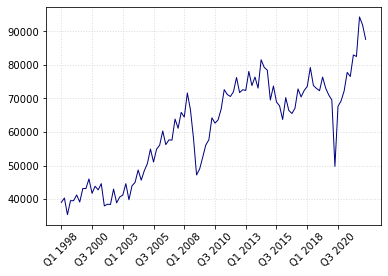

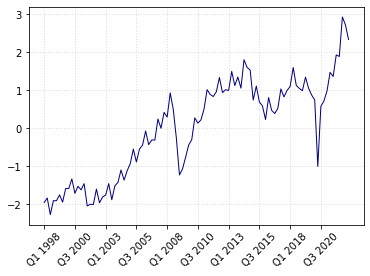

In [12]:
export_country = 'United States'
import_country = 'Canada'

plt.plot(date_array,data_raw[:,np.where(country_array==export_country)[0][0],np.where(country_array==import_country)[0][0]],c="navy",linewidth=1)
plt.xticks(ticks=range(0, len(date_array), 10), rotation=45)
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()
plt.plot(date_array,data[:,np.where(country_array==export_country)[0][0],np.where(country_array==import_country)[0][0]],c="navy",linewidth=1)
plt.xticks(ticks=range(0, len(date_array), 10), rotation=45)
plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
plt.show()

## Estimation

In [13]:
# Potentially extract the optimized parameters such that the program does not have to run again
xl = pd.ExcelFile(path + 'Optimized_Parameters_Check.xlsx')

# Define the Xopt
Xopt = []

# Loop over all sheet names
for sheet_name in xl.sheet_names:

    # Read the sheet to a Numpy object
    params = np.array(xl.parse(sheet_name,header=0))

    # Append the parameters to the Xopt list
    Xopt.append(params)
    
# Correct some vectors to arrays
Xopt[0] = Xopt[0].reshape(d)
Xopt[3] = Xopt[3].reshape(r)
Xopt[4] = Xopt[4].reshape(r)

# Potentially define the optimized parameters to optimize them further
init = Xopt

In [14]:
# Method to get the optimized parameters
def get_opt_theta(data):

    # Define Manifold and its initial values
    manifold = Product([Euclidean(d), Stiefel(n=d_array[0], p=r_array[0]), Stiefel(n=d_array[1], p=r_array[1]), Euclidean(r), Euclidean(r)])
    # Add a intial value if the previously optimized parameters are not utilized as initial value
#     init = [np.zeros(d),np.vstack((np.eye(r_array[0]),np.zeros((d_array[0]-r_array[0],r_array[0])))), np.vstack((np.eye(r_array[1]),np.zeros((d_array[1]-r_array[1],r_array[1])))),np.ones(r),np.ones(r)]
    
    # Define the objective function
    @pymanopt.function.autograd(manifold)
    def llfun(theta_1,theta_2_1,theta_2_2,theta_3,theta_4):

        # Transform variables
        Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-theta_1)*((c_high-1) / (1-c_low))))
        U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(theta_2_2,theta_2_1)
        A_hat = anp.diag(2 / (1+anp.exp(-theta_3)*1/3) - 1)
        B_hat = anp.diag(2 / (1+anp.exp(-theta_4)*1/3) - 1)

        # Define the initial log likelihood value
        llvalue = 0

        # Define initial factor
        f_t = anp.zeros((r,1))

        # Define the inverse of Sigma
        Sigma_inv = anp.linalg.inv(Sigma_hat)

        # Define the U term @ Sigma term to fill in the loop
        U_Sig = 1/d * A_hat @ anp.transpose(U_hat) @ Sigma_inv

        # Define initial X breve
        X_breve = anp.reshape(data[0],(-1,1)) - U_hat @ f_t

        # Loop over all time
        for t in range(1,T):
            # Recursively compute the factors, X breve, and log likelihood value
            f_t =  U_Sig @ X_breve + B_hat @ f_t
            X_breve = anp.reshape(data[t],(-1,1)) - U_hat @ f_t
            llvalue -= 0.5*(anp.transpose(X_breve) @ Sigma_inv @ (X_breve))[0][0]

        return -(llvalue / (T-1) - 1/2 * anp.linalg.slogdet(Sigma_hat)[1] - d/2 * anp.log(2*anp.pi))

    # Get optimized parameter with the Pymanopt package
    problem = Problem(manifold, llfun)
    optimizer = pymanopt.optimizers.ConjugateGradient(max_iterations=30,min_step_size=0.05)

    return optimizer.run(problem, initial_point=init).point

Xopt = get_opt_theta(data)

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    


C:\Users\v.d Bosch\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: divide by zero encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),


 1           -2.0229269065127605e+03    1.75157063e+00    
 2           -2.0229359604635533e+03    2.68661052e+00    
Terminated - min step_size reached after 2 iterations, 48.11 seconds.



In [14]:
# Optionally save the optimalized parameters in an Excel
with pd.ExcelWriter(path + 'Optimized_Parameters.xlsx') as writer:
    
    # Loop through each parameter
    for i, params in enumerate(Xopt, start=1):
        # Convert parameter object to a DataFrame
        df = pd.DataFrame(params)

        # Paste each parameter matrix in its own sheet
        sheet_name = f'Sheet_{i}'
        df.to_excel(writer, sheet_name=sheet_name, index=False)

## Analysis Results

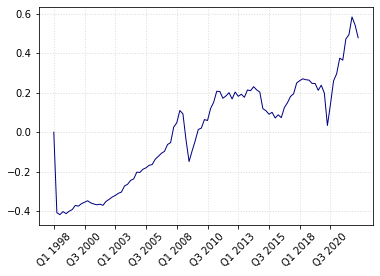

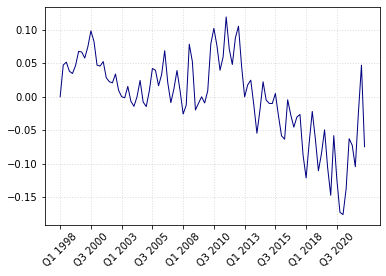

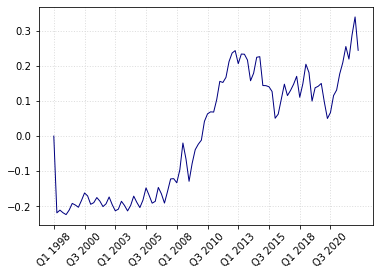

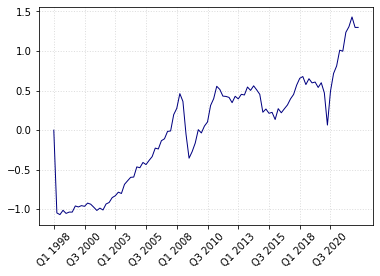

In [15]:
# Transform variables
Sigma_hat = anp.diag(c_low+(c_high-c_low) / (1+anp.exp(-Xopt[0])*((c_high-1) / (1-c_low))))
U_hat = d**0.5 * Sigma_hat**0.5 @ anp.kron(Xopt[2],Xopt[1])
A_hat = anp.diag(2 / (1+anp.exp(-Xopt[3])*1/3) - 1)
B_hat = anp.diag(2 / (1+anp.exp(-Xopt[4])*1/3) - 1)

# Define the initial log likelihood value
llvalue = 0

# Define initial factor
f_t = anp.zeros((r,1))

# Create empty Numpy object to fill
factors_opt = np.zeros(np.append(T,r_array))

# Define the inverse of Sigma
Sigma_inv = anp.linalg.inv(Sigma_hat)

# Define the U term @ Sigma term to fill in the loop
U_Sig = 1/d * A_hat @ anp.transpose(U_hat) @ Sigma_inv

# Loop over all time
for t in range(1,T):
    # Recursively compute the factors, X breve, and log likelihood value
    f_t =  U_Sig @ (anp.reshape(data[t],(-1,1)) - U_hat @ f_t) + B_hat @ f_t

    # Save the factors in the Numpy object
    factors_opt[t] = f_t.reshape(r_array)
    
factors_opt = factors_opt.reshape(T,r)

# Plot all factors
for i in range(r):
    plt.plot(date_array,factors_opt[:,i],c="navy",linewidth=1)
    plt.xticks(ticks=range(0, len(date_array), 10), rotation=45)
    plt.grid(which='major', color='#DDDDDD', linestyle=':', linewidth=1.0)
    plt.show()

## Parameter Estimates

In [16]:
# Create a DataFrame with the optimized parameters
df_U_k = pd.DataFrame(np.hstack([Xopt[1],Xopt[2]]),index=country_array,columns=["Factor 1 $\mathbf{U}_1$","Factor 2 $\mathbf{U}_1$","Factor 1 $\mathbf{U}_2$","Factor 2 $\mathbf{U}_2$"])
# Add a column of ones such that the number of countries can be counted with the groupby()
df_U_k["Number of countries"] = 1

# Show the parameter estimates per category
display(pd.concat([df_country['Continent'],df_U_k],axis=1).groupby(by=["Continent"]).agg({
    "Factor 1 $\mathbf{U}_1$": 'mean',
    "Factor 2 $\mathbf{U}_1$": 'mean',
    "Factor 1 $\mathbf{U}_2$": 'mean',
    "Factor 2 $\mathbf{U}_2$": 'mean',
    "Number of countries": 'sum'
}))

display(pd.concat([df_country['Income groups'],df_U_k],axis=1).groupby(by=["Income groups"]).agg({
    "Factor 1 $\mathbf{U}_1$": 'mean',
    "Factor 2 $\mathbf{U}_1$": 'mean',
    "Factor 1 $\mathbf{U}_2$": 'mean',
    "Factor 2 $\mathbf{U}_2$": 'mean',
    "Number of countries": 'sum'
}).reindex(["Lower-Middle-Income Economies","Upper-Middle-Income Economies","High-Income Economies"]))

,Factor 1 $\mathbf{U}_1$,Factor 2 $\mathbf{U}_1$,Factor 1 $\mathbf{U}_2$,Factor 2 $\mathbf{U}_2$,Number of countries
Continent,,,,,
Africa,0.044453,0.057222,0.062213,0.092288,2
Asia,0.145835,0.092607,0.089320,0.129591,21
Europe,-0.100630,0.167867,-0.116925,0.151815,18
North America,0.019174,0.175599,0.030869,0.082862,3
Oceania,0.118524,0.065947,0.206434,0.093284,2
South America,0.058067,0.059740,0.084102,0.106564,4


,Factor 1 $\mathbf{U}_1$,Factor 2 $\mathbf{U}_1$,Factor 1 $\mathbf{U}_2$,Factor 2 $\mathbf{U}_2$,Number of countries
Income groups,,,,,
Lower-Middle-Income Economies,0.134868,0.055454,0.022033,0.123348,8
Upper-Middle-Income Economies,0.092766,0.098014,0.102491,0.135510,12
High-Income Economies,-0.010840,0.145288,-0.022292,0.129572,30


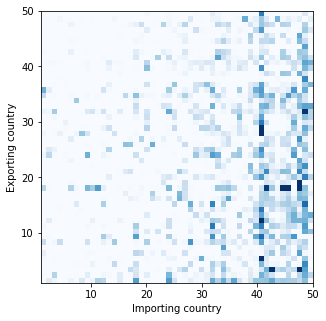

In [23]:
# Create empty Numpy object to fill
Sigma_data = np.zeros((d1,d2))

# Define the reshaped Sigma_hat
Sigma_object = (Sigma_hat**0.5).reshape(d1,d2,d1,d2)

# Get a series of countries sorted by their export volume
sorted_countries = df.groupby(level=0, axis=1).mean().mean().sort_values()

# Loop over the countries in order of export volume
for i1, exporting_country in enumerate(sorted_countries.index):
    for i2, importing_country in enumerate(sorted_countries.index):
        
        # Get the indexes of the countries in the Sigma_hat and fill it into the Numpy object
        exporting_index = np.where(df_country.index==exporting_country)[0][0]
        importing_index = np.where(df_country.index==importing_country)[0][0]
        Sigma_data[i1,i2] = Sigma_object[exporting_index,importing_index,exporting_index,importing_index]
        
# Plot the heatmap
plt.figure(figsize=(5, 5))
plt.imshow(np.log(Sigma_data), cmap='Blues',origin='lower', extent=[1,50,1,50])
plt.xlabel('Importing country')
plt.ylabel('Exporting country')
plt.show()

In [16]:
# Show estimates for A and B (not in report)
display(pd.DataFrame(np.diag(A_hat),index=[r"$\alpha_1$",r"$\alpha_2$",r"$\alpha_3$",r"$\alpha_4$"]))
display(pd.DataFrame(np.diag(B_hat),index=[r"$\beta_1$",r"$\beta_2$",r"$\beta_3$",r"$\beta_4$"]))

,0
$\alpha_1$,0.986045
$\alpha_2$,0.980567
$\alpha_3$,0.999986
$\alpha_4$,0.993607


,0
$\beta_1$,0.998627
$\beta_2$,0.972308
$\beta_3$,1.000000
$\beta_4$,0.986119
